# <font color = 'indianred'>**Sentiment Analysis with the IMDB Dataset using Pre-Trained model** </font>

**Objective:**

In this notebook, we aim to build upon the foundational concepts and techniques introduced in the first notebook, "Sentiment Analysis using Hugging Face Ecosystem." We focus on enhancing the sentiment analysis model's performance by leveraging a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model. The techniques and methods introduced are aligned with current industry standards, making the insights and skills gained from this notebook directly applicable to real-world problems.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference

-----------
**Previous Process**

<img src ="https://drive.google.com/uc?export=view&id=1XkQs_Ohx_bdj3XmliqrKSQmQvBFwL-gJ" width =1000>

-----
**Revised Process**

<img src ="https://drive.google.com/uc?export=view&id=1fuxcrnb4hMlQsYBHhaTsiduV1uBxV58p" width =600>




















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta

<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb

# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
imdb_dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Extract Splits*

In [ ]:
train_split = imdb_dataset['train']
test_validation_dataset = imdb_dataset["test"]

<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [ ]:
# Split the test set into test and validation sets
test_val_splits = imdb_dataset["test"].train_test_split(
    test_size=0.5, seed=42)  # 50% for validation, 50% for test

# Extract the test and validation splits
valid_split = test_val_splits["train"]
test_split = test_val_splits["test"]


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [ ]:
train_split = train_split.shuffle(seed=42).select(range(5000))
val_split = valid_split.shuffle(seed=42).select(range(1000))
test_split = test_split.shuffle(seed=42).select(range(1000))

In [ ]:
train_val = DatasetDict(
    {"train": train_split, "valid": valid_split})

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, padding=True, return_tensors="pt")

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [ ]:
tokenized_dataset= train_val.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)  # We are using the same checkpiont as we have used for tokenizer


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
class_names = tokenized_dataset["train"].features["label"].names
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [ ]:
def compute_metrics(eval_pred):
    combined_metrics = evaluate.combine([evaluate.load("accuracy"),
                                        evaluate.load("f1", average="macro")])

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    evaluations = combined_metrics.compute(
        predictions=predictions, references=labels)
    return evaluations

## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "imdb_complete_data"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # auto_find_batch_size=True,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,


)


##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [ ]:
wandb.login()
%env WANDB_PROJECT = imdb_bert

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=imdb_bert


##  <font color = 'indianred'> **6.7 Training and Validation**

In [ ]:
trainer.train()  # start training

wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
100,0.451800,0.243428,0.906000,0.908766
200,0.294400,0.212737,0.917360,0.918910
300,0.274200,0.239299,0.905760,0.900473
400,0.155500,0.276945,0.918320,0.916945
500,0.178400,0.228615,0.921280,0.922642
600,0.154800,0.233270,0.924320,0.923574
700,0.085400,0.313887,0.921840,0.922919
800,0.069300,0.325167,0.924640,0.924856
900,0.072100,0.331522,0.926160,0.926495


TrainOutput(global_step=939, training_loss=0.18727470891544232, metrics={'train_runtime': 458.7199, 'train_samples_per_second': 32.7, 'train_steps_per_second': 2.047, 'total_flos': 3946665830400000.0, 'train_loss': 0.18727470891544232, 'epoch': 3.0})

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.3315219581127167,
 'eval_accuracy': 0.92616,
 'eval_f1': 0.9264951819702159,
 'eval_runtime': 33.7969,
 'eval_samples_per_second': 369.856,
 'eval_steps_per_second': 23.138,
 'epoch': 3.0}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"], "eval_f1": eval_results["eval_f1"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
valid_preds = np.argmax(valid_output.predictions, axis=1)
valid_labels = np.array(valid_output.label_ids)


In [ ]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


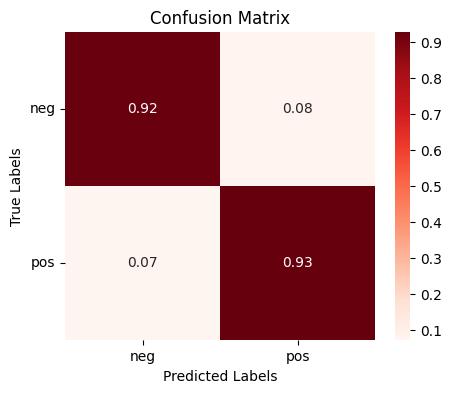

In [ ]:
plot_confusion_matrix(valid_labels, valid_preds, class_labels=list(model.config.id2label.values()))

In [ ]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=valid_preds, y_true=valid_labels,
    class_names=['neg', 'pos'])})


<font color = 'indianred'> *Get best checkpoint*</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 900.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/imdb_complete_data/checkpoint-900'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


<font color = 'indianred'>*Evaluate using Trainer*</font>

In [ ]:
test_results= trainer.evaluate()

In [ ]:
test_results

{'eval_loss': 0.2392488270998001,
 'eval_accuracy': 0.941,
 'eval_f1': 0.944704779756326,
 'eval_runtime': 6.0425,
 'eval_samples_per_second': 165.495,
 'eval_steps_per_second': 1.324}

In [ ]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1": test_results["eval_f1"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [ ]:
test_output = trainer.predict(test_set_tokenized)

In [ ]:
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = np.array(test_output.label_ids)


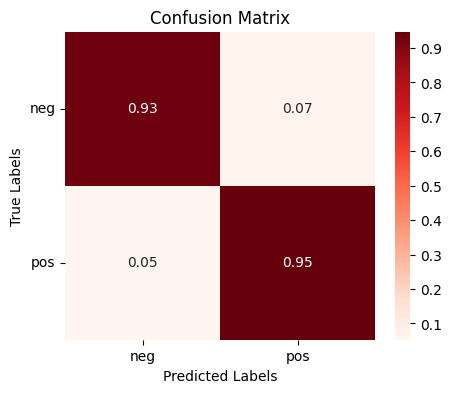

In [ ]:
plot_confusion_matrix(test_labels, test_preds, class_labels=list(model.config.id2label.values()))

In [ ]:
wandb.log({"conf_mat_test": wandb.plot.confusion_matrix(
    preds=test_preds, y_true=test_labels,
    class_names=['neg', 'pos'])})

In [ ]:
wandb.finish()

eval/accuracy,▁▅▁▅▆▇▇▇██
eval/f1,▃▆▁▅▇▇▇███
eval/loss,▃▁▃▅▂▂▇███
eval/runtime,█▁▂▂█▁▁▂▂▂
eval/samples_per_second,▁█▇▇▁██▇▇▆
eval/steps_per_second,▁█▇▇▁██▇▇▆
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
test_accuracy,▁
test_f1,▁


# <Font color = 'indianred'> **8. Model Inference**



In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0)

<font color = 'indianred'> **Test the pipeline on a single example**

In [ ]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds


[{'label': 'neg', 'score': 0.9990369081497192}]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [ ]:
predictions = custom_pipeline(test_split['text'], truncation=True)

In [ ]:
predictions[0:10]


[{'label': 'neg', 'score': 0.9990369081497192},
 {'label': 'pos', 'score': 0.9991457462310791},
 {'label': 'pos', 'score': 0.9990401864051819},
 {'label': 'pos', 'score': 0.9982479810714722},
 {'label': 'pos', 'score': 0.9991907477378845},
 {'label': 'neg', 'score': 0.9991136193275452},
 {'label': 'neg', 'score': 0.9988266825675964},
 {'label': 'pos', 'score': 0.9990770816802979},
 {'label': 'pos', 'score': 0.9989417195320129},
 {'label': 'pos', 'score': 0.998728334903717}]